In [18]:
# using Pkg
# Pkg.add("NetCDF")
# Pkg.add("CairoMakie")
# Pkg.add("LaTeXStrings")

In [19]:
using CairoMakie
using LaTeXStrings
using Printf
using NetCDF
using LinearAlgebra

In [20]:
# Data: COBE Sea Surface Temperature
#
# Monthly 1° x 1° SST dataset from 1891 to present from 
# the JMA. Datasets uses 3D Var to fill gaps.
# https://psl.noaa.gov/data/gridded/data.cobe.html
#
# The file has approximately 160 MB. 
#
# Data set dimensions:
# - number of time steps ≈ 1590 
#   (until 06/2023, downloaded in October 2023)
# - number of longitudinal grid nodes: 360
# - number of latitudinal grid nodes: 180
# - dim(sst) = 360 × 180 × 1590 
# - when vectorized: 64800 × 1590
# - after eliminating missing values 
#   (no measurements on land): 43799 × 1590
#      
# As an alternative to the command below, you
# may simply download the file manually using the
# link and place it into the folder of the script.

filename = "sst.mon.mean.nc"
if isfile(filename) == false
    Downloads.download("https://downloads.psl.noaa.gov/Datasets/COBE/sst.mon.mean.nc", 
    string(dirname(Base.source_path()), "\\", filename))
end

In [21]:
# ncinfo(filename)
sst = ncread(filename, "sst");
lon = ncread(filename, "lon");
lat = ncread(filename, "lat");

# split time index into months and years
# Time series starts on 1/1/1891
time = ncread(filename, "time");
nmonths = length(time);
year = zeros(nmonths);
month = zeros(nmonths);
for i in 1 : nmonths
    year[i] = 1891 + floor((i-1)/12)
    m = mod(i, 12);
    if m == 0
        month[i] = 12
    else
        month[i] = m
    end
end;

In [22]:
# function to create vectorized data from 
# the NC data structure, while excluding
# invalid entries (i.e., entries on land)
function createVectors(sst,lon,lat)

    # size of data set
    n = size(sst)
    n_lon, n_lat, n_t = n[1], n[2], n[3]

    # find number of existing entries
    val_lon = zeros(Int64, n_lon * n_lat)
    val_lat = zeros(Int64, n_lon * n_lat)
    n_exist = 0
    for i in 1 : n_lon
        for j in 1 : n_lat
            
            # invalid entries are Inf
            if sst[i, j, 1] < 1e10
                n_exist += 1
                val_lon[n_exist] = i
                val_lat[n_exist] = j
            end
        end
    end
    val_lon = val_lon[1:n_exist]
    val_lat = val_lat[1:n_exist]

    # create arrays
    Xlon = zeros(n_exist)
    Xlat = zeros(n_exist)
    SST = zeros(n_exist, n_t)

    # fill data into arrays
    s = 0
    for i in 1 : n_exist
        Xlon[i] = lon[val_lon[i]]
        Xlat[i] = lat[val_lat[i]]
        SST[i, :] = sst[val_lon[i], val_lat[i], :]
    end

    return Xlon, Xlat, SST
end;

# Function to normlaize a vector to [0, 1].
# This is only used for plotting later on.
function normalizeVector(x)
    lb = 0.0;
    dx = maximum(x) - minimum(x);
    return ((((x .- minimum(x)) ./ dx) .+ lb) ./ (1 + lb))
end;

In [23]:
# number of months to study
nstudy = 120;

# start and end inidices to use the last (nstudy) months
iStart = nmonths - nstudy + 1;
iEnd = nmonths;

# create data vectors for time frame of interest
Xlon, Xlat, SST = createVectors(sst[:, :, iStart:iEnd], lon, lat);
yearStudy = year[iStart:iEnd];
monthStudy = month[iStart:iEnd];

println(size(SST))

(43799, 120)


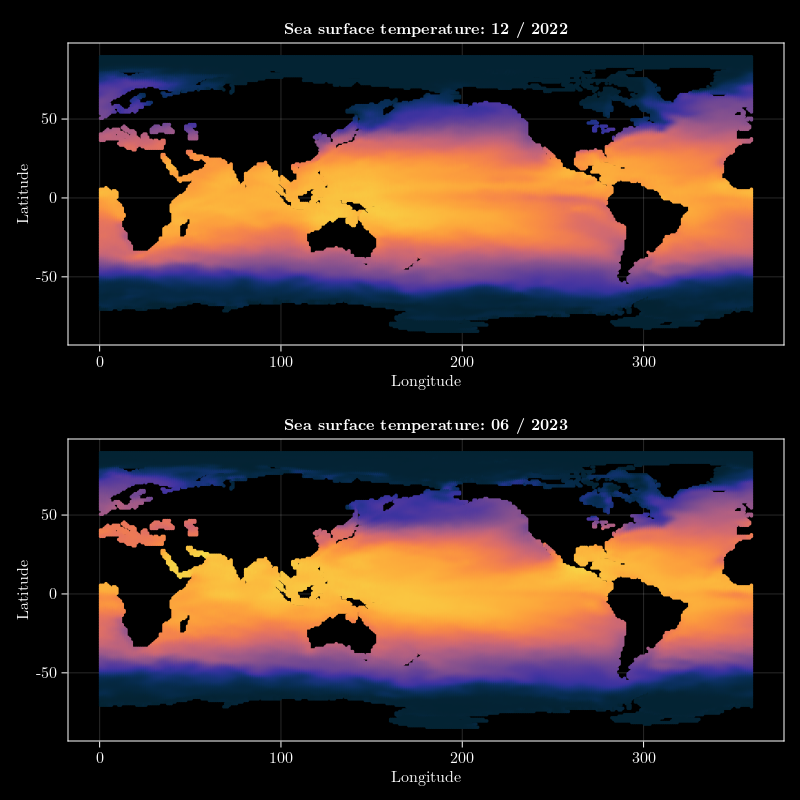

In [35]:
# Plotting

# calculate indices for color range (for plotting)
crange = normalizeVector(SST);

dark_latexfonts = merge(theme_black(), theme_latexfonts())
set_theme!(dark_latexfonts)

fig = Figure(resolution = (800, 800), backgroundcolor = "black")
ax = Axis(fig[1, 1], backgroundcolor = "black", 
    title=@sprintf("Sea surface temperature: %02d / %d", monthStudy[nstudy-6], yearStudy[nstudy-6]), 
    xlabel="Longitude", ylabel="Latitude")
sc = scatter!(ax, Xlon, Xlat, color = crange[:, nstudy-6], 
    colorrange = (0,1), markersize = 5, 
    colormap = :thermal)

ax = Axis(fig[2, 1], backgroundcolor = "black", 
    title=@sprintf("Sea surface temperature: %02d / %d", monthStudy[nstudy], yearStudy[nstudy]), 
    xlabel="Longitude", ylabel="Latitude")
sc = scatter!(ax, Xlon, Xlat, color = crange[:, nstudy], 
    colorrange = (0,1), markersize = 5, 
    colormap = :thermal)

fig

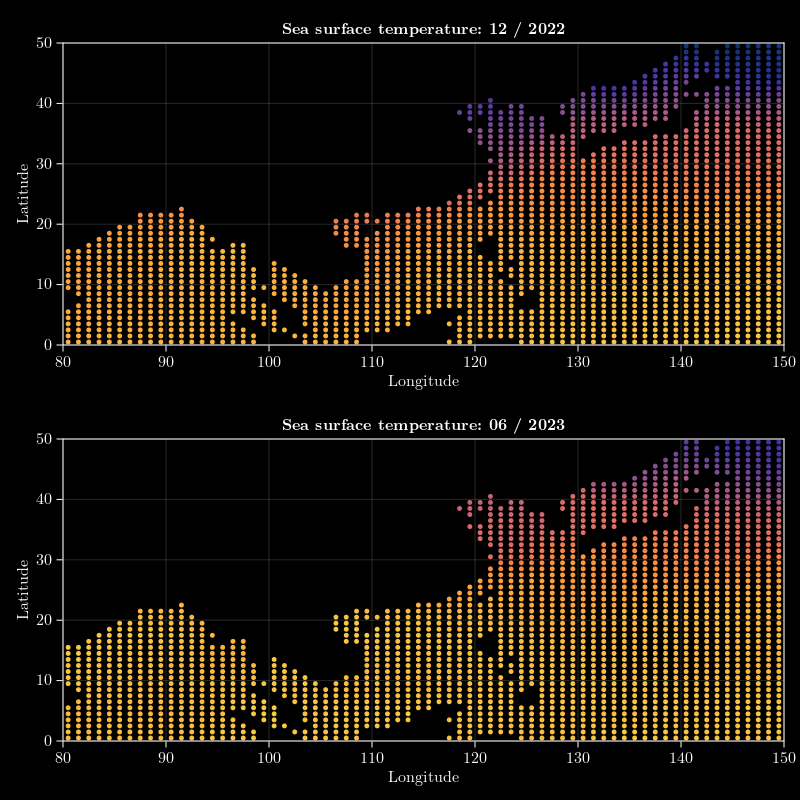

In [25]:
# "zoom in"
dark_latexfonts = merge(theme_black(), theme_latexfonts())
set_theme!(dark_latexfonts)

fig = Figure(resolution = (800, 800), backgroundcolor = "black")
ax = Axis(fig[1, 1], backgroundcolor = "black", limits = ((80, 150), (0, 50)),
    title=@sprintf("Sea surface temperature: %02d / %d", monthStudy[nstudy-6], yearStudy[nstudy-6]), 
    xlabel="Longitude", ylabel="Latitude")
sc = scatter!(ax, Xlon, Xlat, color = crange[:, nstudy-6], 
    colorrange = (0,1), markersize = 7, 
    colormap = :thermal)
ax = Axis(fig[2, 1], backgroundcolor = "black", limits = ((80, 150), (0, 50)),
    title=@sprintf("Sea surface temperature: %02d / %d", monthStudy[nstudy], yearStudy[nstudy]), 
    xlabel="Longitude", ylabel="Latitude")
sc = scatter!(ax, Xlon, Xlat, color = crange[:, nstudy], 
    colorrange = (0,1), markersize = 7, 
    colormap = :thermal)
fig

In [26]:
# Create video

# animation settings
# framerate = 12
# hue_iterator = range(1, nstudy, length=nstudy)

# fig = Figure(resolution = (1600, 800), backgroundcolor = "black")
# ax = Axis(fig[1, 1], backgroundcolor = "black", 
#     title=@sprintf("Sea surface temperature: %02d / %d", monthStudy[1], yearStudy[1]), 
#     xlabel="Longitude", ylabel="Latitude")
# sc = scatter!(ax, Xlon, Xlat, color = crange[:, 1], 
#     colorrange = (0,1), markersize = 10, 
#     colormap = :thermal)

# record(fig, "SST.mp4", hue_iterator;
#         framerate = framerate) do hue
#     sc.color = crange[:, Int(hue)]
#     ax.title = @sprintf("Sea surface temperature: %02d / %d", monthStudy[Int(hue)], yearStudy[Int(hue)]);
# end

# Singlar Value Decomposition (SVD) 
# \& Dynamic Mode Decomposition (DMD)

We now use the vectorized data from before to first 
* identify singular vectors (a.k.a. POD modes ("_Proper Orthogonal Decomosition_")) and then 
* use the singular vectors to compute a DMD matrix of rank $r$.

### SVD

In [27]:
# Set up the regressor matrix for the identification of 
# a linear dynamical system
Z = SST[:, 1 : end - 1];
Z_dash = SST[:, 2 : end];

# Singular Value Decomposition (SVD) of the data
# (Julia automatically performs the economy version)
U, S, V = svd(Z);

println(size(U))
println(size(S))
println(size(V'))

(43799, 119)
(119,)
(119, 119)


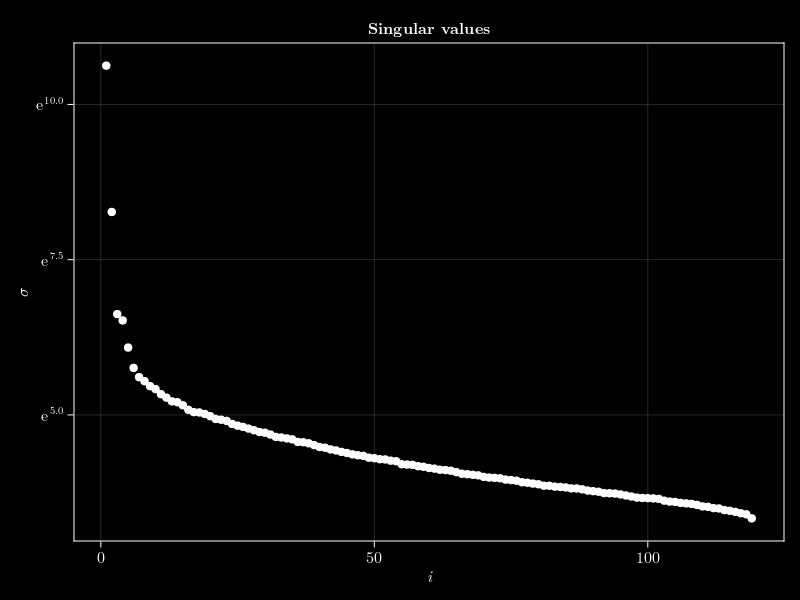

In [28]:
# Plot singular values
f = Figure()
ax = Axis(f[1, 1], xlabel = L"i", ylabel = L"\sigma", yscale=log,
    title="Singular values")
scatter!(ax, range(1,length(S),length=length(S)), S, color="white")
f

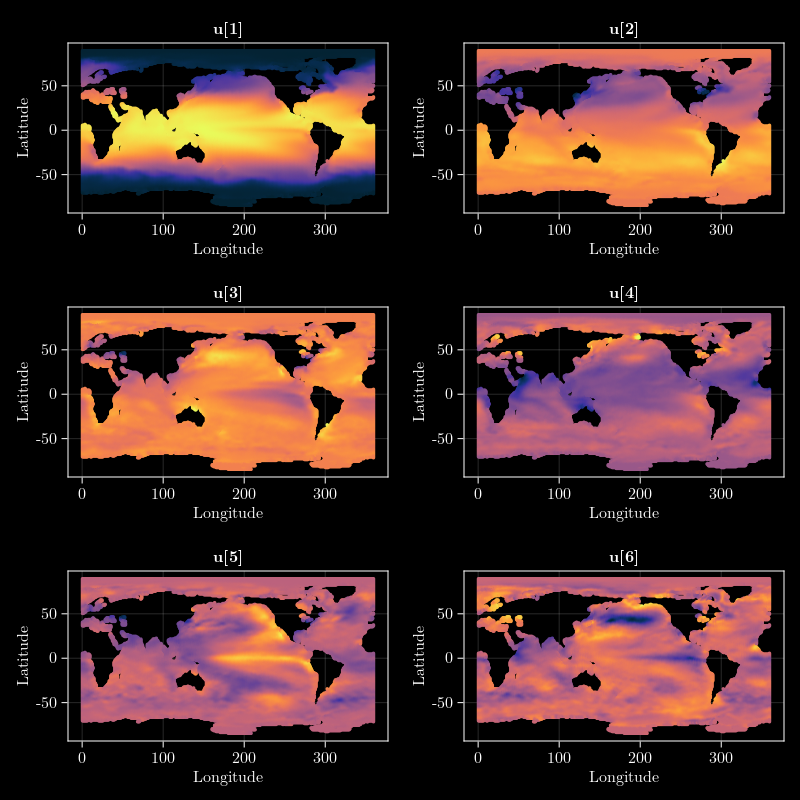

In [29]:
# visualization of the leading singular vectors
fig = Figure(resolution = (800, 800), backgroundcolor = "black")
for i in 1 : 3
    for j in 1 : 2
        k = (i-1)*2 + j
        ax = Axis(fig[i, j], backgroundcolor = "black", 
            title=@sprintf("u[%d]", k), 
            xlabel="Longitude", ylabel="Latitude")

        sc = scatter!(ax, Xlon, Xlat, color = normalizeVector(U[:, k]), 
            colorrange = (0,1), markersize = 5, 
            colormap = :thermal)
    end
end
fig

### DMD
For a detailed introduction, see, e.g., **Brunton, Budisic, Kaiser \& Kutz, "Modern Koopman thoery for dynamical systems," _SIAM Review_ 64(2), 2022**. ([Link](https://doi.org/10.1137/21M1401243))

In [30]:
# rank of reduced matrix
r = 100;

# compute the reduced DMD matrix using the SVD matrices form before
A_tilde = U[:, 1 : r]' * Z_dash * V[:, 1 : r] * diagm( 1 ./ S[1 : r] );

# Eigenvalue problem in discrete-time
μ = eigvals(A_tilde);
P = eigvecs(A_tilde);

# Calculate the eigenvalues in continuous-time 
# (time scale in years: this requires a multiplication 
#  by 12, since the time step in the data is 1 month)
#
# μ = exp(λ · Δt) ⇔ λ = log(μ) / Δt (with Δt = 1/12)
λ = log.(μ) * 12

# Compute the frequency ω of the modes in years
# Recall: Imaginary part of the eigenvalue is 
# responsible for the oscillations:
# cos(ωt) + j · sin(ωt)
ω = imag.(λ)

# Sort according to ω
i_sort = sortperm(ω, by=abs)

ω = ω[i_sort]
μ = μ[i_sort]
P = P[:, i_sort]
λ = λ[i_sort]

# DMD modes
Φ = Z_dash * V[:, 1 : r] * diagm( 1 ./ S[1 : r] ) * P;


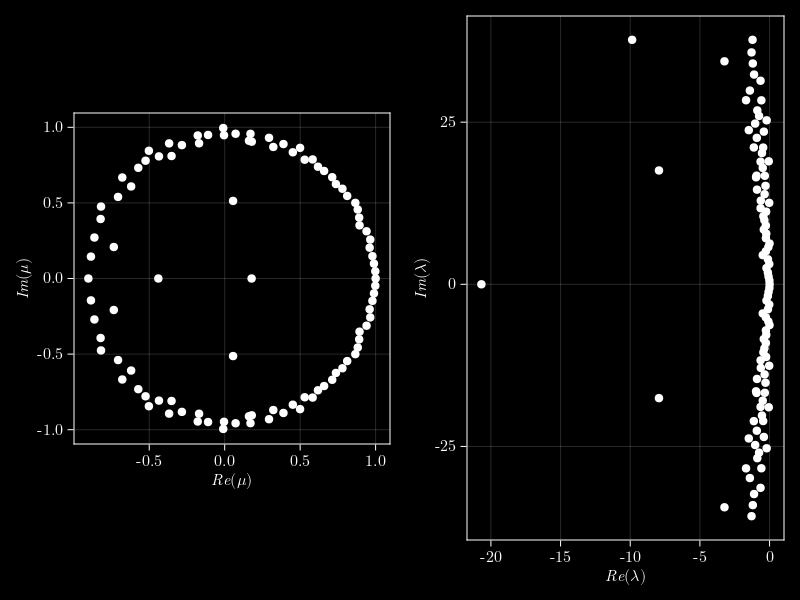

In [31]:
f = Figure()
ax = Axis(f[1, 1], xlabel = L"Re(\mu)", ylabel = L"Im(\mu)", aspect=DataAspect())
scatter!(ax, real(μ), imag(μ), color="white")
ax = Axis(f[1, 2], xlabel = L"Re(\lambda)", ylabel = L"Im(\lambda)")
scatter!(ax, real(λ), imag(λ), color="white")
f

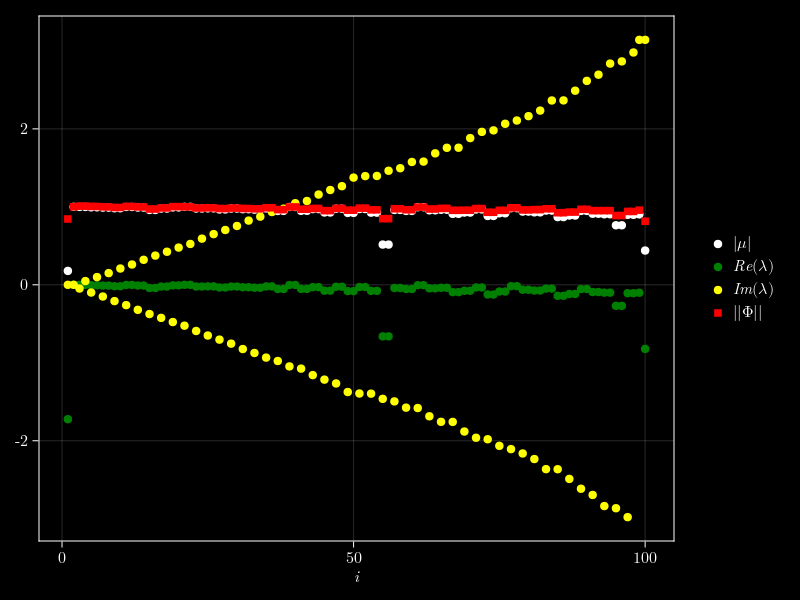

In [32]:
normPhi = sqrt.(real.(diag(Φ'*Φ)))

f = Figure()
ax = Axis(f[1, 1], xlabel = L"i", ylabel = " ")
scatter!(ax, range(1,r,length=r), abs.(μ), color="white", label = L"|\mu|")
scatter!(ax, range(1,r,length=r), real.(λ)/12, color="green", label = L"Re(\lambda)")
scatter!(ax, range(1,r,length=r), imag.(λ)/12, color="yellow", label = L"Im(\lambda)")
scatter!(ax, range(1,r,length=r), normPhi, color="red", marker=:rect, label = L"||\Phi||")
f[1, 2] = Legend(f, ax, framevisible = false)
f

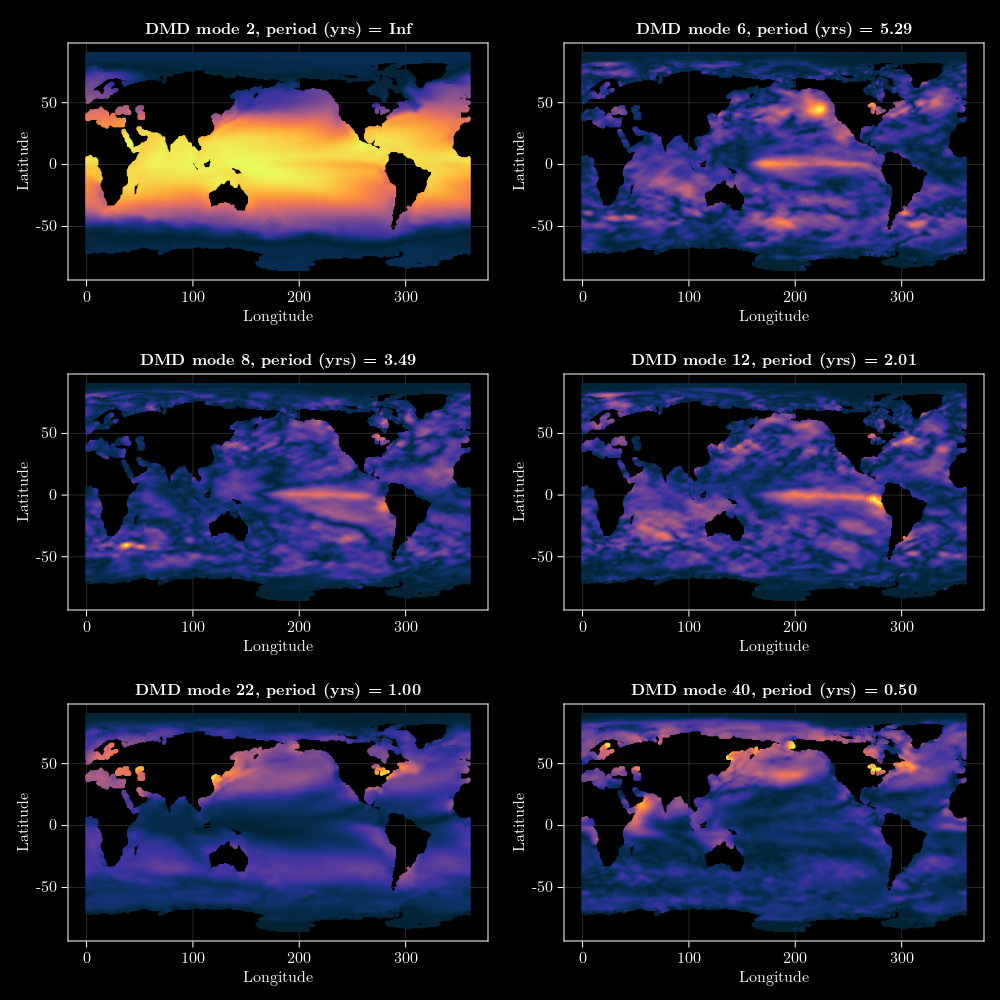

In [33]:
# visualization of selected DMD modes
vals_to_plot = [2,6,8,12,22,40]
fig = Figure(resolution = (1000, 1000), backgroundcolor = "black")
for i in 1 : 3
    for j in 1 : 2
        k = (i-1)*2 + j
        ax = Axis(fig[i, j], backgroundcolor = "black", 
            title=@sprintf("DMD mode %d, period (yrs) = %.2f", vals_to_plot[k], 2*pi/ω[vals_to_plot[k]]), 
            xlabel="Longitude", ylabel="Latitude")

        sc = scatter!(ax, Xlon, Xlat, color = normalizeVector(abs.(Φ[:, vals_to_plot[k]])), 
            colorrange = (0,1), markersize = 5, 
            colormap = :thermal)
    end
end
fig